# Генерация признаков 

###  Исследование временного ряда потребления энергии

* Датасет взят с [kaggle.com](https://www.kaggle.com/code/kingoffitpredict/nta-timeseries/input)
* [Подробная информация о датасете](https://www.kaggle.com/datasets/srinuti/residential-power-usage-3years-data-timeseries/)
* [Документация по tsfresh](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html)

In [121]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import kurtosis
from scipy.signal import find_peaks

from scipy import stats
from statistics import variance

import tsfresh
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings, ComprehensiveFCParameters, MinimalFCParameters

import featuretools as ft

from tqdm import tqdm
import gc

from datetime import datetime as dt

import warnings
import os

In [74]:
warnings.filterwarnings('ignore')

In [75]:
%matplotlib inline

In [76]:
POWER_CONSUMPTION_DATASET_PATH = './power_usage_2016_to_2020.csv'

## Подготавливаем данные

In [77]:
df = pd.read_csv(POWER_CONSUMPTION_DATASET_PATH, index_col=[0], parse_dates=[0])

df

,Value (kWh),day_of_week,notes
StartDate,,,
2016-01-06 00:00:00,1.057,2,weekday
2016-01-06 01:00:00,1.171,2,weekday
2016-01-06 02:00:00,0.560,2,weekday
2016-01-06 03:00:00,0.828,2,weekday
2016-01-06 04:00:00,0.932,2,weekday
...,...,...,...
2020-07-07 19:00:00,1.307,1,weekday
2020-07-07 20:00:00,2.872,1,weekday
2020-07-07 21:00:00,2.138,1,weekday


In [78]:

df.drop(['day_of_week', 'notes'], axis=1, inplace=True)
df.head()

,Value (kWh)
StartDate,
2016-01-06 00:00:00,1.057
2016-01-06 01:00:00,1.171
2016-01-06 02:00:00,0.560
2016-01-06 03:00:00,0.828
2016-01-06 04:00:00,0.932


In [79]:
df.sort_index(inplace=True) 

df

,Value (kWh)
StartDate,
2016-01-06 00:00:00,1.057
2016-01-06 01:00:00,1.171
2016-01-06 02:00:00,0.560
2016-01-06 03:00:00,0.828
2016-01-06 04:00:00,0.932
...,...
2020-12-06 19:00:00,2.311
2020-12-06 20:00:00,1.958
2020-12-06 21:00:00,2.274


In [80]:
df.resample('w').sum().head()



,Value (kWh)
StartDate,
2016-01-10,212.491
2016-01-17,34.516
2016-01-24,0.000
2016-01-31,0.000
2016-02-07,88.199


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35952 entries, 2016-01-06 00:00:00 to 2020-12-06 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value (kWh)  35952 non-null  float64
dtypes: float64(1)
memory usage: 561.8 KB


In [82]:
is_monotonic_increasing = df.index.is_monotonic_increasing
is_monotonic_decreasing = df.index.is_monotonic_decreasing

print(f"Индекс монотонный по возрастанию: {is_monotonic_increasing}")
print(f"Индекс монотонный по убыванию: {is_monotonic_decreasing}")


Индекс монотонный по возрастанию: True
Индекс монотонный по убыванию: False


In [83]:
is_monotonic = is_monotonic_increasing or is_monotonic_decreasing

is_monotonic

True

Данные монотонны

In [84]:
# Посмотрим на начальную и конечную даты наблюдений

print('Дата начала наблюдений: {}'.format(df.index.min()))
print('Дата окончания наблюдений: {}'.format(df.index.max()))
print('Временной отрезок: {}'.format(df.index.max() - df.index.min()))

Дата начала наблюдений: 2016-01-06 00:00:00
Дата окончания наблюдений: 2020-12-06 23:00:00
Временной отрезок: 1796 days 23:00:00


In [85]:
df.columns = ['value']
df.head()

,value
StartDate,
2016-01-06 00:00:00,1.057
2016-01-06 01:00:00,1.171
2016-01-06 02:00:00,0.560
2016-01-06 03:00:00,0.828
2016-01-06 04:00:00,0.932


<Axes: xlabel='StartDate'>

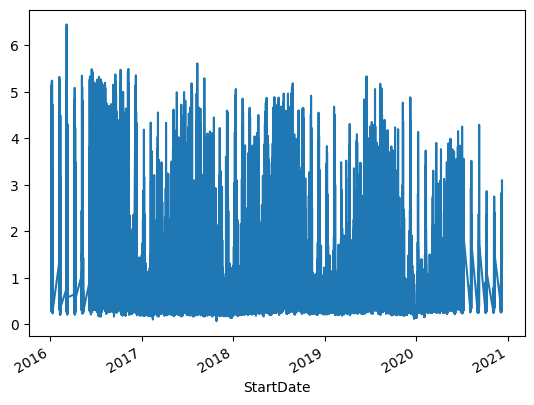

In [86]:
df["value"].plot()

In [87]:
df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week 
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

df.head(15)

,value,year,quarter,month,week,day,dayofweek
StartDate,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2


In [88]:
df['rolling_window'] = df['value'].rolling(6).mean()

df.head(15)

,value,year,quarter,month,week,day,dayofweek,rolling_window
StartDate,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,0.813500
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,0.714333
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,0.601333
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,0.562167


In [89]:
df['kurtosis'] = df['value'].rolling(6).apply(lambda x: kurtosis(x)) #/ эксцессы

df.head(15)

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis
StartDate,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN,NaN
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN,NaN
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN,NaN
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,0.813500,-1.114059
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,0.714333,-1.291905
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,0.601333,-1.273392
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,0.562167,-1.371188


In [90]:
df['peaks'] = df['value'].rolling(6).apply(lambda x: len(find_peaks(x)[0]))

In [91]:
df['expanding_window'] = df['value'].expanding(3).mean()

df.head(15)

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis,peaks,expanding_window
StartDate,,,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN,NaN,NaN,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN,NaN,NaN,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN,NaN,NaN,0.929333
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN,NaN,NaN,0.904000
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN,NaN,NaN,0.909600
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,0.813500,-1.114059,2.0,0.813500
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,0.714333,-1.291905,1.0,0.763286
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,0.601333,-1.273392,1.0,0.729500
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,0.562167,-1.371188,2.0,0.684556


In [92]:
# TODO: перенести в собственный глобальный пакет utils

def stat_df(df, column):
  mean = round(df[column].mean(), 3)
  
  return {
    'mean': mean,
  }

In [93]:
stat_df(df, 'rolling_window') # Финальные значения раскрывающегося окна

{'mean': 0.892}

In [94]:
stat_df(df, 'value') # По столбцу value

{'mean': 0.892}

Супер

In [95]:
df['lag_-1'] = df['value'].shift(-1)
df['lag_1'] = df['value'].shift(1)

df.head(15)

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis,peaks,expanding_window,lag_-1,lag_1
StartDate,,,,,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN,NaN,NaN,NaN,1.171,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN,NaN,NaN,NaN,0.560,1.057
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN,NaN,NaN,0.929333,0.828,1.171
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN,NaN,NaN,0.904000,0.932,0.560
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN,NaN,NaN,0.909600,0.333,0.828
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,0.813500,-1.114059,2.0,0.813500,0.462,0.932
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,0.714333,-1.291905,1.0,0.763286,0.493,0.333
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,0.601333,-1.273392,1.0,0.729500,0.325,0.462
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,0.562167,-1.371188,2.0,0.684556,0.294,0.493


In [96]:
try:
    df.drop('lag_-1', axis=1, inplace=True)
except:
    pass

for i in range(1, 12):
    df['lag_' + str(i)] = df['value'].shift(i)
    
df.head(15)

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis,peaks,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
StartDate,,,,,,,,,,,,,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN,NaN,NaN,...,1.057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN,NaN,NaN,...,1.171,1.057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN,NaN,NaN,...,0.560,1.171,1.057,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,0.813500,-1.114059,2.0,...,0.828,0.560,1.171,1.057,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,0.714333,-1.291905,1.0,...,0.932,0.828,0.560,1.171,1.057,NaN,NaN,NaN,NaN,NaN
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,0.601333,-1.273392,1.0,...,0.333,0.932,0.828,0.560,1.171,1.057,NaN,NaN,NaN,NaN
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,0.562167,-1.371188,2.0,...,0.462,0.333,0.932,0.828,0.560,1.171,1.057,NaN,NaN,NaN


In [97]:
df['lag_7_mean'] = df['lag_7'].rolling(7).mean()
df['diff'] = df['value'].diff()

In [98]:
df.dropna(inplace=True)

In [99]:
df['year'] = df['year'].apply(lambda x: 2022 - x)

df.head()

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis,peaks,...,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_7_mean,diff
StartDate,,,,,,,,,,,,,,,,,,,,,
2016-01-06 13:00:00,0.421,6,1,1,1,6,2,0.410333,0.207071,1.0,...,0.294,0.325,0.493,0.462,0.333,0.932,0.828,0.560,0.763286,-0.005
2016-01-06 14:00:00,0.447,6,1,1,1,6,2,0.430667,-0.035539,1.0,...,0.273,0.294,0.325,0.493,0.462,0.333,0.932,0.828,0.682714,0.026
2016-01-06 15:00:00,0.496,6,1,1,1,6,2,0.464333,-0.013531,1.0,...,0.723,0.273,0.294,0.325,0.493,0.462,0.333,0.932,0.561857,0.049
2016-01-06 16:00:00,0.523,6,1,1,1,6,2,0.506000,0.341204,0.0,...,0.426,0.723,0.273,0.294,0.325,0.493,0.462,0.333,0.523857,0.027
2016-01-06 17:00:00,3.647,6,1,1,1,6,2,0.993333,1.193105,0.0,...,0.421,0.426,0.723,0.273,0.294,0.325,0.493,0.462,0.444571,3.124


In [100]:
# TODO: перенести в собственный глобальный пакет utils

def is_dayoff(row):   
    '''
    Возвращает 1, если текущий день - выходной или праздничный, 0 - если будний. 
    ''' 
    
    match (row['month'], row['day'], row['dayofweek'], row['week']):
        # Праздничные дни
        case (1, 1, _, _):  # Новый год
            return 1
        case (1, _, 0, 8):  # День Мартина Лютера Кинга
            return 1
        case (2, _, 0, 10):  # Президентский день
            return 1
        case (5, _, 0, 22):  # День памяти
            return 1
        case (7, 4, _, _):  # День независимости
            return 1
        case (9, _, 0, 37):  # День труда
            return 1
        case (9, _, 0, 42):  # День Колумба
            return 1
        case (11, 11, _, _):  # День ветеранов
            return 1
        case (11, _, 3, 48):  # День благодарения
            return 1
        case (12, 25, _, _):  # Рождество
            return 1

        # Выходные (суббота и воскресенье)
        case (_, _, dayofweek, _) if dayofweek >= 5:
            return 1

        # Будние дни
        case _:
            return 0

In [101]:
df['is_dayoff'] = df.apply(is_dayoff, axis=1)

df.head()

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis,peaks,...,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_7_mean,diff,is_dayoff
StartDate,,,,,,,,,,,,,,,,,,,,,
2016-01-06 13:00:00,0.421,6,1,1,1,6,2,0.410333,0.207071,1.0,...,0.325,0.493,0.462,0.333,0.932,0.828,0.560,0.763286,-0.005,0
2016-01-06 14:00:00,0.447,6,1,1,1,6,2,0.430667,-0.035539,1.0,...,0.294,0.325,0.493,0.462,0.333,0.932,0.828,0.682714,0.026,0
2016-01-06 15:00:00,0.496,6,1,1,1,6,2,0.464333,-0.013531,1.0,...,0.273,0.294,0.325,0.493,0.462,0.333,0.932,0.561857,0.049,0
2016-01-06 16:00:00,0.523,6,1,1,1,6,2,0.506000,0.341204,0.0,...,0.723,0.273,0.294,0.325,0.493,0.462,0.333,0.523857,0.027,0
2016-01-06 17:00:00,3.647,6,1,1,1,6,2,0.993333,1.193105,0.0,...,0.426,0.723,0.273,0.294,0.325,0.493,0.462,0.444571,3.124,0


Построим график плотности распределения и посчитаем основные математические показатели.

<Axes: ylabel='Density'>

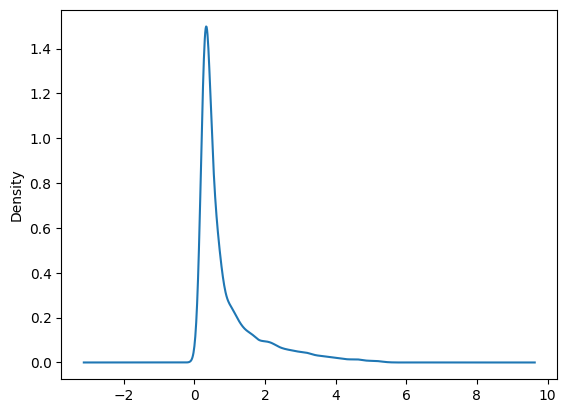

In [102]:
df["value"].plot.kde()

In [103]:
df["value"].skew()

2.1280514921082836

In [104]:
df["value"].kurtosis()

4.530668709320001

Как мы видим, из за большого коэффициента присутствует явное смещение вправо и вытянусть вверх.

Попробуем сгенерировать дополнительные признаки.

In [105]:
df.columns

Index(['value', 'year', 'quarter', 'month', 'week', 'day', 'dayofweek',
       'rolling_window', 'kurtosis', 'peaks', 'expanding_window', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_7_mean', 'diff', 'is_dayoff'],
      dtype='object')

In [106]:
df["peaks"] = df["value"].rolling(6).apply(lambda x: len(find_peaks(x)[0]))

<Axes: xlabel='StartDate'>

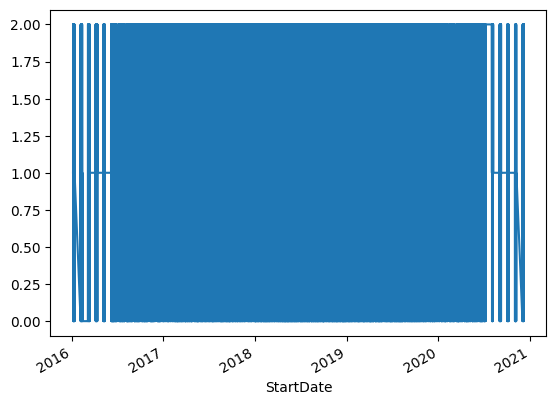

In [107]:
df['peaks'].plot()

Поскольку не удалось на предыдущих признаках

Займемся заполнение датасета сначала, только уже с использование `featuretools`

In [108]:
# Загружаем первичные данные, но не переводим дату в индекс (это важно)
df_fe = pd.read_csv(POWER_CONSUMPTION_DATASET_PATH, parse_dates=[0])

df_fe

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday
...,...,...,...,...
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday


In [109]:
df_fe.drop(['day_of_week', 'notes'], axis=1, inplace=True)

In [110]:
df_fe.head()

,StartDate,Value (kWh)
0,2016-01-06 00:00:00,1.057
1,2016-01-06 01:00:00,1.171
2,2016-01-06 02:00:00,0.560
3,2016-01-06 03:00:00,0.828
4,2016-01-06 04:00:00,0.932


In [111]:
es = ft.EntitySet(id = 'data')
es.add_dataframe(
    dataframe_name='timeseries',
    dataframe=df_fe,
    index="transaction_id"
)

primitives = ['day', 'is_weekend', 'week', 'year', 'minute', 'hour', 'weekday', 'cum_mean']    # Список фичей для генерации
dataframes = {
    "timeseries" : (df_fe,"StartDate")
}

# Запускаем создание новых признаков
feature_matrix, feature_defs = ft.dfs(entityset = es,                                          # Какой EntiteSet обрабатываем
                                      dataframes = dataframes,       
                                    target_dataframe_name="timeseries",                  # Какой датафрейм изменяем
                                      trans_primitives = primitives,                           # Какие фичи создаем
                                      verbose=1)  

Built 9 features
Elapsed: 00:00 | Progress: 100%|██████████


In [112]:
feature_matrix.head()

,Value (kWh),CUM_MEAN(Value (kWh)),DAY(StartDate),HOUR(StartDate),IS_WEEKEND(StartDate),MINUTE(StartDate),WEEK(StartDate),WEEKDAY(StartDate),YEAR(StartDate)
transaction_id,,,,,,,,,
0,1.057,1.057000,6,0,False,0,1,2,2016
1,1.171,1.114000,6,1,False,0,1,2,2016
2,0.560,0.929333,6,2,False,0,1,2,2016
3,0.828,0.904000,6,3,False,0,1,2,2016
4,0.932,0.909600,6,4,False,0,1,2,2016


<Axes: ylabel='Density'>

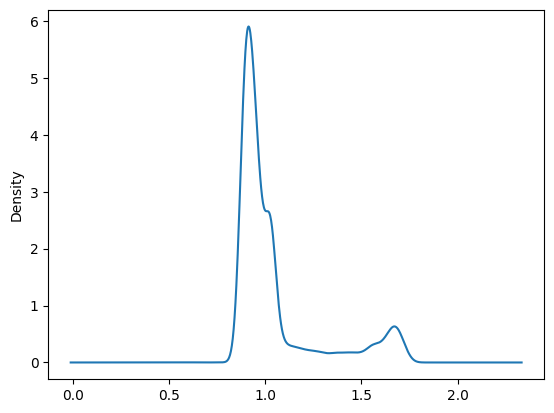

In [162]:
feature_matrix['CUM_MEAN(Value (kWh))'].plot.kde()

Это лучший результат генерации фич, видно небольшой подъем между `1.5` и `2`.

Возможно, он ложный, но скорее всего, основан на росте при `1`

In [113]:
# Список всех доступных примитивных фичей
ft.primitives.list_primitives()

,name,type,description,valid_inputs,return_type
0,num_zero_crossings,aggregation,Determines the number of times a list crosses ...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Integer) (Semant...
1,all,aggregation,Calculates if all values are 'True' in a list.,<ColumnSchema (Logical Type = BooleanNullable)...,<ColumnSchema (Logical Type = Boolean)>
2,max_count,aggregation,Calculates the number of occurrences of the ma...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
3,num_unique,aggregation,"Determines the number of distinct values, igno...",<ColumnSchema (Semantic Tags = ['category'])>,<ColumnSchema (Logical Type = IntegerNullable)...
4,any,aggregation,Determines if any value is 'True' in a list.,<ColumnSchema (Logical Type = BooleanNullable)...,<ColumnSchema (Logical Type = Boolean)>
...,...,...,...,...,...
198,is_quarter_start,transform,Determines the is_quarter_start attribute of a...,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = BooleanNullable)>
199,cum_mean,transform,Calculates the cumulative mean.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
200,subtract_numeric,transform,Performs element-wise subtraction of two lists.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
201,date_to_time_zone,transform,Determines the timezone of a datetime.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Categorical) (Se...


Подключаем tsfresh

In [114]:
df_2 = pd.read_csv(POWER_CONSUMPTION_DATASET_PATH, parse_dates=[0])

df_2

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday
...,...,...,...,...
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday


In [116]:
df_2["id"] = df_2["day_of_week"]

In [117]:
df_2["StartDate"] = pd.to_datetime(df_2["StartDate"])

In [118]:
df_2 = df_2.sort_values(by="StartDate")

In [119]:
df_2 = df_2[["id", "StartDate", "Value (kWh)"]]

df_2

,id,StartDate,Value (kWh)
0,2,2016-01-06 00:00:00,1.057
1,2,2016-01-06 01:00:00,1.171
2,2,2016-01-06 02:00:00,0.560
3,2,2016-01-06 03:00:00,0.828
4,2,2016-01-06 04:00:00,0.932
...,...,...,...
35347,6,2020-12-06 19:00:00,2.311
35348,6,2020-12-06 20:00:00,1.958
35349,6,2020-12-06 21:00:00,2.274
35350,6,2020-12-06 22:00:00,1.617


In [122]:
# Извлекаем признаки из преобразованного датасета
# Выбираем набор параметров для извлечения признаков
parameters = ComprehensiveFCParameters()

eatures = extract_features(df_2, column_id="id", column_sort="StartDate", column_value="Value (kWh)", default_fc_parameters=parameters)

Feature Extraction: 100%|██████████| 7/7 [01:20<00:00, 11.48s/it]


In [123]:
eatures

,Value (kWh)__variance_larger_than_standard_deviation,Value (kWh)__has_duplicate_max,Value (kWh)__has_duplicate_min,Value (kWh)__has_duplicate,Value (kWh)__sum_values,Value (kWh)__abs_energy,Value (kWh)__mean_abs_change,Value (kWh)__mean_change,Value (kWh)__mean_second_derivative_central,Value (kWh)__median,...,Value (kWh)__fourier_entropy__bins_5,Value (kWh)__fourier_entropy__bins_10,Value (kWh)__fourier_entropy__bins_100,Value (kWh)__permutation_entropy__dimension_3__tau_1,Value (kWh)__permutation_entropy__dimension_4__tau_1,Value (kWh)__permutation_entropy__dimension_5__tau_1,Value (kWh)__permutation_entropy__dimension_6__tau_1,Value (kWh)__permutation_entropy__dimension_7__tau_1,Value (kWh)__query_similarity_count__query_None__threshold_0.0,Value (kWh)__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,1.0,4405.645096,7743.206275,0.293783,-0.000063,0.000052,0.4890,...,0.200814,0.470291,1.733404,1.744803,3.038391,4.491944,6.015030,7.322492,NaN,5.466857
1,0.0,0.0,0.0,1.0,4511.970864,7995.927703,0.309231,0.000022,-0.000016,0.4910,...,0.170467,0.451339,1.789778,1.749025,3.049172,4.502219,6.026883,7.336504,NaN,5.309429
2,0.0,0.0,0.0,1.0,4452.445753,7773.349659,0.301850,-0.000131,-0.000026,0.5080,...,0.136002,0.387337,1.727144,1.751277,3.058302,4.521268,6.054321,7.354493,NaN,5.279429
3,0.0,0.0,0.0,1.0,4664.576073,8654.804435,0.311785,-0.000097,-0.000039,0.4960,...,0.200814,0.450990,1.680264,1.749631,3.036848,4.480962,5.998242,7.298483,NaN,5.312429
4,0.0,0.0,0.0,1.0,4517.293853,8295.461836,0.310642,-0.000302,0.000031,0.4930,...,0.200814,0.409490,1.821139,1.752009,3.055601,4.522231,6.070148,7.380730,NaN,5.230714
5,0.0,0.0,0.0,1.0,4702.324673,8644.375613,0.316378,-0.000129,-0.000076,0.5145,...,0.200814,0.465793,1.694542,1.750220,3.051045,4.516079,6.059951,7.370728,NaN,5.361143
6,0.0,0.0,0.0,1.0,4801.667400,9123.894693,0.323968,0.000126,-0.000011,0.5195,...,0.200814,0.485093,1.830307,1.748129,3.047780,4.507223,6.037565,7.346932,NaN,5.263286


In [124]:
df_2['id'].unique()

array([2, 3, 4, 5, 6, 0, 1])

Снова обозначим 1 как рабочий день, а 0 как выходной для создания y

In [126]:
data = np.array(['1', '1', '1', '1', '1','0','0'])
 
y = pd.Series(data)

y

0    1
1    1
2    1
3    1
4    1
5    0
6    0
dtype: object

In [127]:
impute(eatures)

features_filtered = select_features(eatures, y)

features_filtered

""
0
1
2
3
4
5
6


In [128]:
features_filtered_direct = extract_relevant_features(df_2, y, column_id='id', column_sort='StartDate')

Feature Extraction: 100%|██████████| 7/7 [01:04<00:00,  9.27s/it]


In [130]:
features_filtered_direct

""
0
1
2
3
4
5
6


<Axes: ylabel='Density'>

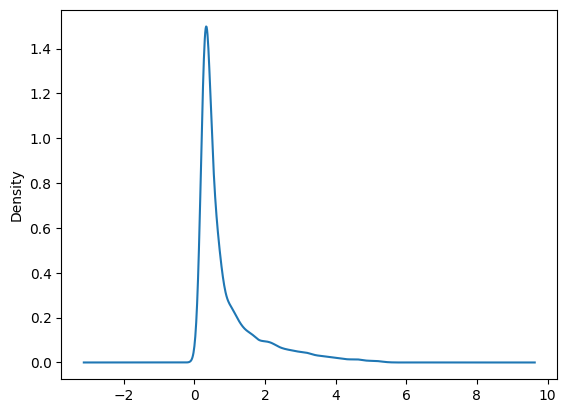

In [144]:
df["value"].plot.kde()

Генерацией фич вручную, неплохой результат, но можно лучше

In [132]:
df["value"].skew() # Ассиметрия

2.1280514921082836

In [133]:
df["value"].kurtosis() # Эксцесс

4.530668709320001

Как мы видим, из за большого коэффициента присутствует явное смещение вправо и вытянусть вверх

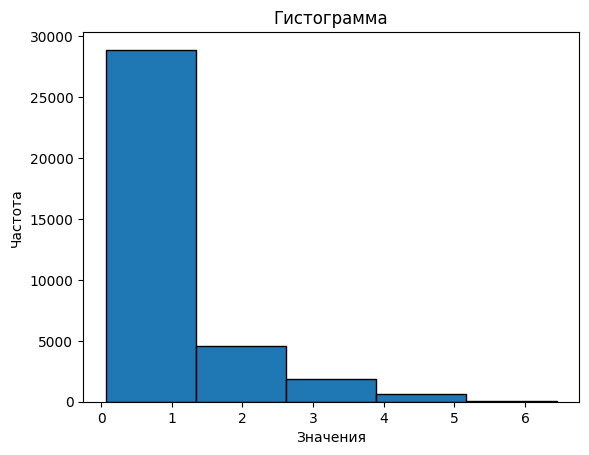

In [134]:
plt.hist(df['value'], bins=5, edgecolor="black")
plt.title("Гистограмма")
plt.xlabel("Значения")
plt.ylabel("Частота")
plt.show()

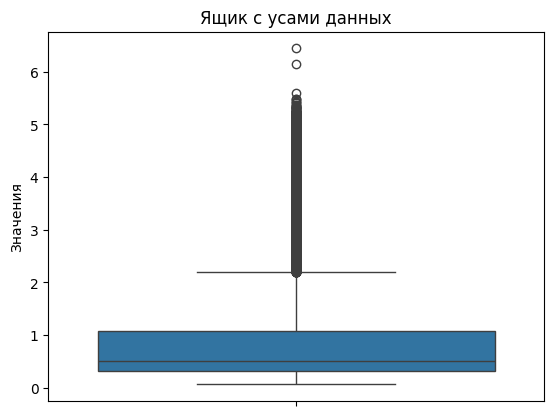

In [135]:
sns.boxplot(df['value'], orient="v")
plt.title("Ящик с усами данных")
plt.ylabel("Значения")
plt.show()

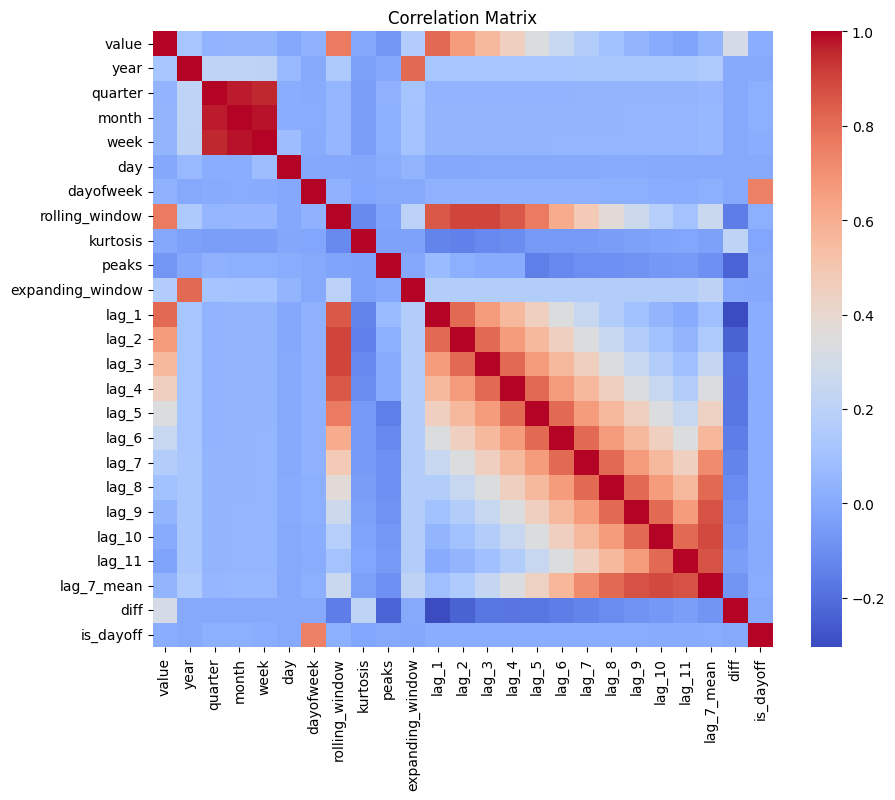

In [137]:
numerical_features = df.select_dtypes(include=['number'])

correlation_matrix = numerical_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [145]:
import pandas as pd
from tsfresh.feature_extraction import extract_features, ComprehensiveFCParameters

# Убедимся, что в исходном датасете есть уникальный идентификатор
if 'id' not in df_2.columns:
    df_2['id'] = range(len(df_2))  # Создаем уникальный идентификатор, если его нет

# Извлекаем признаки
parameters = ComprehensiveFCParameters()
features = extract_features(
    df_2,
    column_id="id",
    column_sort="StartDate",
    column_value="Value (kWh)",
    default_fc_parameters=parameters
)

# Приведение индекса в соответствие с ключами для объединения
features.reset_index(inplace=True)  # Индекс переводим в колонку
features.rename(columns={"index": "id"}, inplace=True)  # Указываем, что это идентификатор

# Объединяем оригинальный датасет с извлеченными признаками
df_2_with_features = pd.merge(df_2, features, on="id", how="left")

# Итоговый результат: df_2_with_features содержит все исходные данные и 783 новых признака
print(df_2_with_features.head())

Feature Extraction: 100%|██████████| 7/7 [01:27<00:00, 12.52s/it]

   id           StartDate  Value (kWh)  \
0   2 2016-01-06 00:00:00        1.057   
1   2 2016-01-06 01:00:00        1.171   
2   2 2016-01-06 02:00:00        0.560   
3   2 2016-01-06 03:00:00        0.828   
4   2 2016-01-06 04:00:00        0.932   

   Value (kWh)__variance_larger_than_standard_deviation  \
0                                                0.0      
1                                                0.0      
2                                                0.0      
3                                                0.0      
4                                                0.0      

   Value (kWh)__has_duplicate_max  Value (kWh)__has_duplicate_min  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0              

In [146]:
df_2_with_features

,id,StartDate,Value (kWh),Value (kWh)__variance_larger_than_standard_deviation,Value (kWh)__has_duplicate_max,Value (kWh)__has_duplicate_min,Value (kWh)__has_duplicate,Value (kWh)__sum_values,Value (kWh)__abs_energy,Value (kWh)__mean_abs_change,...,Value (kWh)__fourier_entropy__bins_5,Value (kWh)__fourier_entropy__bins_10,Value (kWh)__fourier_entropy__bins_100,Value (kWh)__permutation_entropy__dimension_3__tau_1,Value (kWh)__permutation_entropy__dimension_4__tau_1,Value (kWh)__permutation_entropy__dimension_5__tau_1,Value (kWh)__permutation_entropy__dimension_6__tau_1,Value (kWh)__permutation_entropy__dimension_7__tau_1,Value (kWh)__query_similarity_count__query_None__threshold_0.0,Value (kWh)__mean_n_absolute_max__number_of_maxima_7
0,2,2016-01-06 00:00:00,1.057,0.0,0.0,0.0,1.0,4452.445753,7773.349659,0.301850,...,0.136002,0.387337,1.727144,1.751277,3.058302,4.521268,6.054321,7.354493,NaN,5.279429
1,2,2016-01-06 01:00:00,1.171,0.0,0.0,0.0,1.0,4452.445753,7773.349659,0.301850,...,0.136002,0.387337,1.727144,1.751277,3.058302,4.521268,6.054321,7.354493,NaN,5.279429
2,2,2016-01-06 02:00:00,0.560,0.0,0.0,0.0,1.0,4452.445753,7773.349659,0.301850,...,0.136002,0.387337,1.727144,1.751277,3.058302,4.521268,6.054321,7.354493,NaN,5.279429
3,2,2016-01-06 03:00:00,0.828,0.0,0.0,0.0,1.0,4452.445753,7773.349659,0.301850,...,0.136002,0.387337,1.727144,1.751277,3.058302,4.521268,6.054321,7.354493,NaN,5.279429
4,2,2016-01-06 04:00:00,0.932,0.0,0.0,0.0,1.0,4452.445753,7773.349659,0.301850,...,0.136002,0.387337,1.727144,1.751277,3.058302,4.521268,6.054321,7.354493,NaN,5.279429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35947,6,2020-12-06 19:00:00,2.311,0.0,0.0,0.0,1.0,4801.667400,9123.894693,0.323968,...,0.200814,0.485093,1.830307,1.748129,3.047780,4.507223,6.037565,7.346932,NaN,5.263286
35948,6,2020-12-06 20:00:00,1.958,0.0,0.0,0.0,1.0,4801.667400,9123.894693,0.323968,...,0.200814,0.485093,1.830307,1.748129,3.047780,4.507223,6.037565,7.346932,NaN,5.263286
35949,6,2020-12-06 21:00:00,2.274,0.0,0.0,0.0,1.0,4801.667400,9123.894693,0.323968,...,0.200814,0.485093,1.830307,1.748129,3.047780,4.507223,6.037565,7.346932,NaN,5.263286
35950,6,2020-12-06 22:00:00,1.617,0.0,0.0,0.0,1.0,4801.667400,9123.894693,0.323968,...,0.200814,0.485093,1.830307,1.748129,3.047780,4.507223,6.037565,7.346932,NaN,5.263286


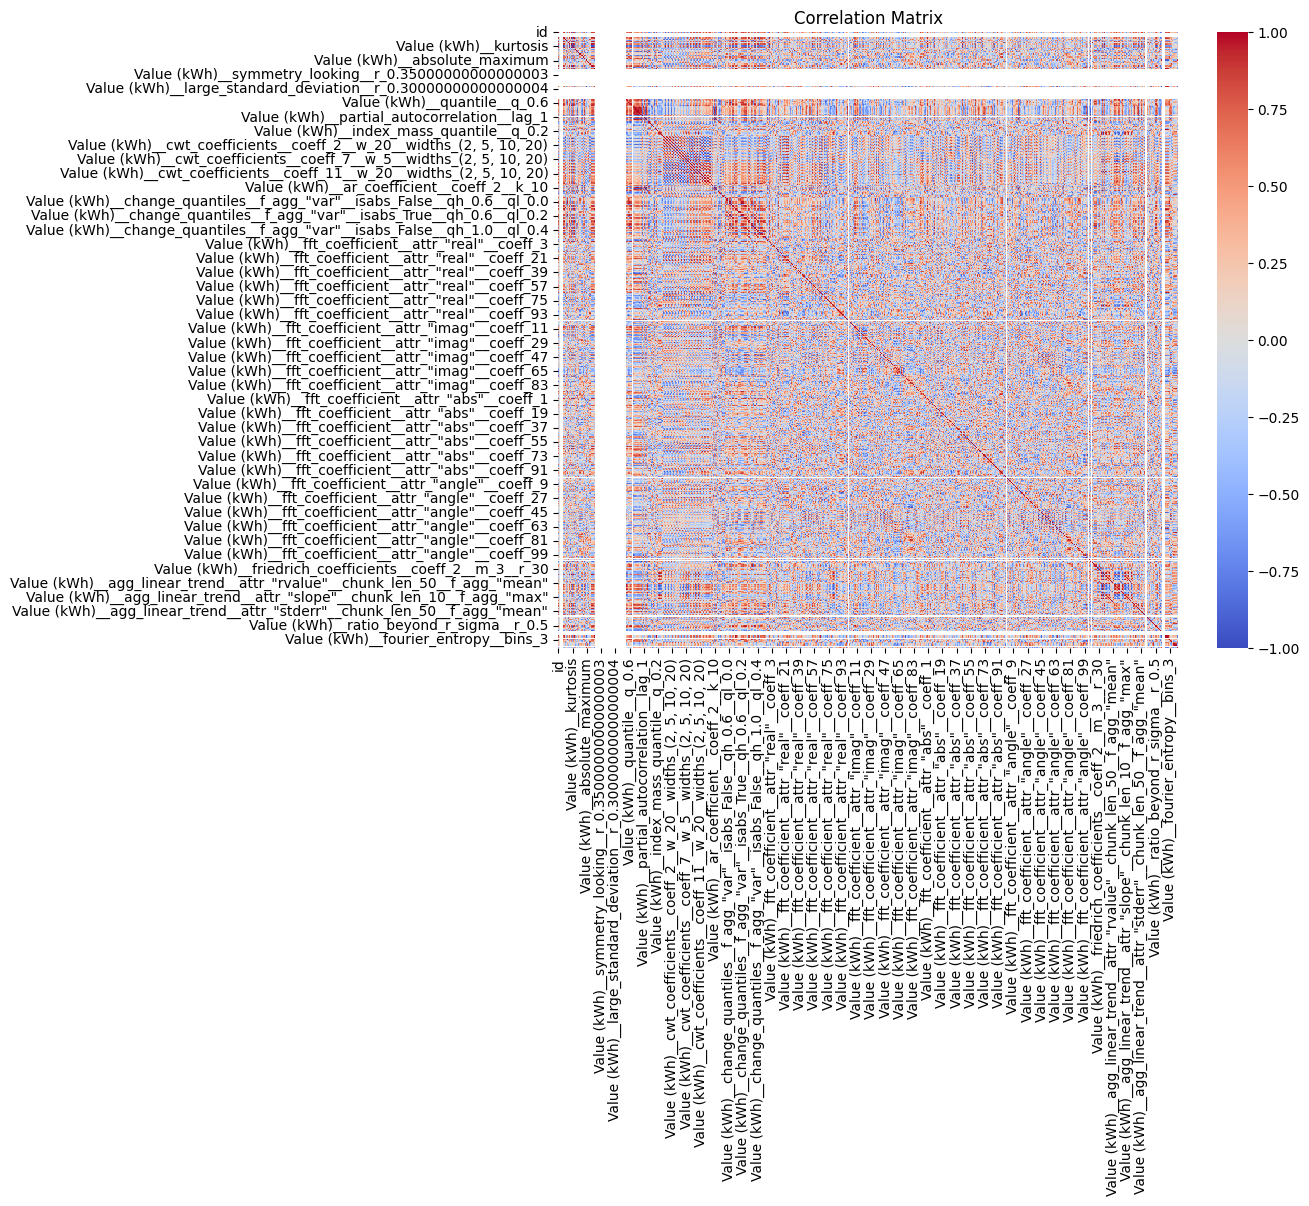

In [147]:
numerical_features = df_2_with_features.select_dtypes(include=['number'])

correlation_matrix = numerical_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [166]:
df_2_with_features.columns

Index(['id', 'StartDate', 'Value (kWh)',
       'Value (kWh)__variance_larger_than_standard_deviation',
       'Value (kWh)__has_duplicate_max', 'Value (kWh)__has_duplicate_min',
       'Value (kWh)__has_duplicate', 'Value (kWh)__sum_values',
       'Value (kWh)__abs_energy', 'Value (kWh)__mean_abs_change',
       ...
       'Value (kWh)__fourier_entropy__bins_5',
       'Value (kWh)__fourier_entropy__bins_10',
       'Value (kWh)__fourier_entropy__bins_100',
       'Value (kWh)__permutation_entropy__dimension_3__tau_1',
       'Value (kWh)__permutation_entropy__dimension_4__tau_1',
       'Value (kWh)__permutation_entropy__dimension_5__tau_1',
       'Value (kWh)__permutation_entropy__dimension_6__tau_1',
       'Value (kWh)__permutation_entropy__dimension_7__tau_1',
       'Value (kWh)__query_similarity_count__query_None__threshold_0.0',
       'Value (kWh)__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=786)

<Axes: ylabel='Density'>

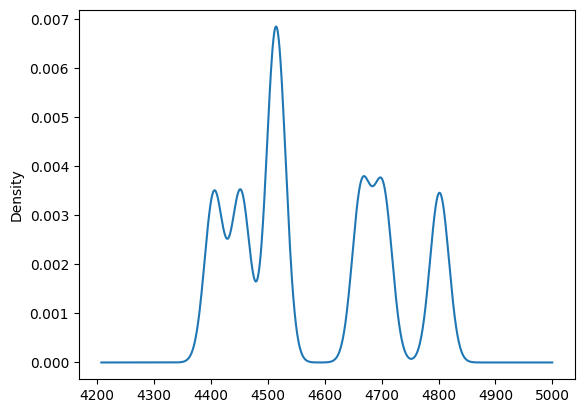

In [164]:
df_2_with_features['Value (kWh)__sum_values'].plot.kde()

<Axes: ylabel='Density'>

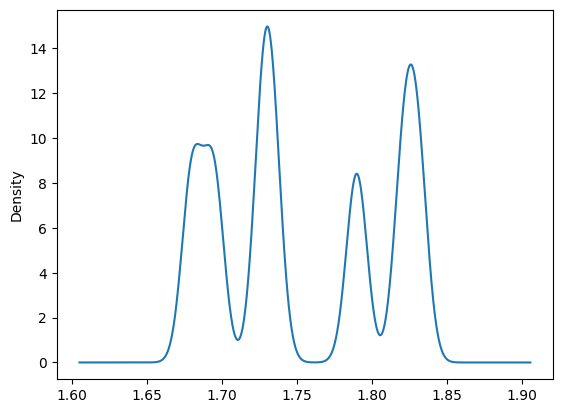

In [165]:
df_2_with_features['Value (kWh)__fourier_entropy__bins_100'].plot.kde()

Лучше чем генерация вручную, но хуже, чем через `featuretools`